# FINM 36700

# Homework #6 Submission

**Group B 28**

## 2. Investigating Momentum

#### In this section, we empirically investigate some concerns regarding AQR’s new momentum product.

#### On GitHub, find the data file, “momentum data.xlsx”.


- #### The third tab contains the momentum factor as an excess return: $\tilde{r}^{mom}$


- #### The fourth tab contains returns on portfolios corresponding to scored momentum deciles.
    - #### $\tilde{r}^{mom(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the “losers” with the lowest past returns.
    - #### $\tilde{r}^{mom(10)}$ denotes the portfolio of stocks in the highest momentum decile.


- #### The fifth tab gives portfolios sorted by momentum and size.
    - #### $\tilde{r}^{momSU}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
    - #### $\tilde{r}^{momBD}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.


#### Note that the Fama-French momentum return, $\tilde{r}^{mom:FF}$, given in the third tab, is constructed by FF as,


#### $$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### Import

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader as dr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15, 6]
import matplotlib.cm as cm


import warnings
warnings.filterwarnings("ignore")

### Helper Functions

In [3]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.5)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.5)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [4]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [5]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

### Reading Data

In [18]:
ff_factors = pd.read_excel(r'momentum_data.xlsx',sheet_name='factors (excess returns)',index_col='Date')
size_ports = pd.read_excel(r'momentum_data.xlsx',sheet_name='size_sorts (total returns)',index_col='Date')
rf = pd.read_excel(r'momentum_data.xlsx',sheet_name='risk-free rate',index_col='Date')
mom_deciles = pd.read_excel(r'momentum_data.xlsx',sheet_name='deciles (total returns)',index_col='Date')
momentum = pd.read_excel(r'momentum_data.xlsx',sheet_name = 'momentum (excess returns)',index_col='Date')

# Plug the UMD into the factors sheet
ff_factors['UMD'] = momentum['UMD']

## 2) Investigating Momentum

### 2.1) Is momentum still profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2023?


Investigate by filling out the summary statistics below for the full-sample and three sub-samples.


### 2.1.a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{mom:FF}$

|<caption>Table 1: Momentum performance over time.</caption>|Subsample|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|
|1927 - 2023|||||||||
|1927 - 1993|||||||||
|1994 - 2008|||||||||
|2009 - 2023|||||||||


In [4]:
# Create a dict with all of the subsample periods containing a list for start year end year inside.

sub_samples = {
              '1927-2023' : ['1927','2023'],
              '1927-1993' : ['1927','1993'],
              '1994-2008' : ['1994','2008'],
              '2009-2023' : ['2009','2023']
              }

# Traverse all of the dict items for obatining the start year and end year for each period and create a new
# sub_mom and sub_ff data for each specified period.
# For the mean, vol, sharpe, and skewness, we calculate it from performance_summary function for each period of time
# For the corr to the market, we calculate the total correlation and extract the corr UMD for each period to the MKT
# For the corr to the High-Mi-Low factor, we calculate the total correlation and extract the corr UMD for each period to the HML

mom_sum = []
for k,v in sub_samples.items():
    sub_mom = momentum.loc[sub_samples[k][0]:sub_samples[k][1]]
    sub_ff = ff_factors.loc[sub_samples[k][0]:sub_samples[k][1]]
    mom_summary = performance_summary(sub_mom)
    mom_summary = mom_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_summary['Corr Mkt'] = sub_ff.corr().loc['MKT',['UMD']]
    mom_summary['Corr Val'] = sub_ff.corr().loc['HML',['UMD']]
    mom_summary.index = [k]
    mom_sum.append(mom_summary)

mom_summary = pd.concat(mom_sum)
mom_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
1927-2023,0.074791,0.163069,0.458647,-2.992077,-0.346337,-0.404836
1927-1993,0.090113,0.159991,0.563242,-3.808977,-0.362537,-0.494960
1994-2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.129402
2009-2023,-0.026030,0.161623,-0.161052,-2.698287,-0.385511,-0.309380


### 2.1.b) Has momentum changed much over time, as seen through these subsample statistics?

Yes. The momentum has been great since from 1927 to 2008. However, it turned negative in the last period. Significant disruptions, such as the financial crisis, and the COVID-19 pandemic may have influenced this behavior.

The negative correlations of UMD between Market and Value Factors make UMD an appealing factor for diversification if the original portfolio focuses on those two factors.

###  2.1.c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

Yes. Since the momentum has positive returns overall in most of the periods, except during 2009-2023, when the return was slightly negative; the overall performance of momentum indicates that it should be a valuable factor. In addition, the correlation between UMD and MKT, SMB is negative; it may still be valuable in diversifying portfolios even if the return decreased to nearly zero after subtracting transaction costs.

### 2.2) The case is about whether a long-only implementation of momentum is valuable.

#### Construct your own long-only implementation:

#### $$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

#### Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

#### $$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


#### For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


### 2.2.a) Fill out Table 2 for the data in the period 1994-2023.


|<caption>Table 2: Long-only momentum performance.</caption>|1994-2023|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|Long-and-short, $\tilde{r}^{mom:FF}$|||||||||
|Long only, $\tilde{r}^{momU:FF}$|||||||||

#### 2.2.a.1 Long only portfolio $$\tilde{r}^{momU: FF}$$

In [21]:
# Calculate the long-only implementation of momentum: equal weighted long BIG Hi and SMALL Hi
mom_rtn_long = pd.DataFrame(((1/2*(size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']))-rf['RF']),columns = ['UMD'])
mom_rtn_long.head()

,UMD
Date,
1927-01-31,-0.00050
1927-02-28,0.04730
1927-03-31,-0.00200
1927-04-30,0.02315
1927-05-31,0.06705


In [28]:
# Make another copy of ff_factor, whose name is ff_long, with new long-only momentum factor adding
ff_long = ff_factors.copy()
ff_long['UMD'] = mom_rtn_long['UMD']
ff_long.head()

,MKT,SMB,HML,UMD
Date,,,,
1927-01-31,-0.0006,-0.0037,0.0454,-0.00050
1927-02-28,0.0418,0.0004,0.0294,0.04730
1927-03-31,0.0013,-0.0165,-0.0261,-0.00200
1927-04-30,0.0046,0.0030,0.0081,0.02315
1927-05-31,0.0544,0.0153,0.0473,0.06705


In [29]:
# Calculate the summary statistics using the performance_summary statistics of 1994 and the following.
mom_rtn_long_summary = performance_summary(mom_rtn_long['1994':])
mom_rtn_long_summary = mom_rtn_long_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
mom_rtn_long_summary['Corr Mkt'] = ff_long.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_summary['Corr Val'] = ff_long.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_summary.index = ['Long Only']
mom_rtn_long_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long Only,0.115447,0.17835,0.647306,-0.463528,0.901697,-0.13085


#### 2.2.a.2 Long-short portfolio $$\tilde{r}^{mom: FF}$$

In [30]:
# Calculate the long-short implementation of momentum: equally weighted long (BIG Hi + SMALL Hi) & short (BIG Lo + SMALL Lo)
mom_rtn_long_short = pd.DataFrame((1/2*((size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) 
                              - (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR']))),columns = ['UMD'])
mom_rtn_long_short.head()

,UMD
Date,
1927-01-31,0.00360
1927-02-28,-0.02150
1927-03-31,0.03615
1927-04-30,0.04300
1927-05-31,0.03005


In [31]:
# Make another copy of ff_factor, whose name is ff_long_short, with new long-short momentum factor adding
ff_long_short = ff_factors.copy()
ff_long_short['UMD'] = mom_rtn_long_short['UMD']
ff_long_short.head()

,MKT,SMB,HML,UMD
Date,,,,
1927-01-31,-0.0006,-0.0037,0.0454,0.00360
1927-02-28,0.0418,0.0004,0.0294,-0.02150
1927-03-31,0.0013,-0.0165,-0.0261,0.03615
1927-04-30,0.0046,0.0030,0.0081,0.04300
1927-05-31,0.0544,0.0153,0.0473,0.03005


In [32]:
# Calculate the summary statistics using the performance_summary statistics of 1994 and the following.
mom_rtn_long_short_summary = performance_summary(mom_rtn_long_short['1994':])
mom_rtn_long_short_summary = mom_rtn_long_short_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
mom_rtn_long_short_summary['Corr Mkt'] = ff_long_short.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_short_summary['Corr Val'] = ff_long_short.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_short_summary.index = ['Long and Short']
mom_rtn_long_short_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171


In [33]:
# concat two DataFrames into one
mom_comparsion = pd.concat([mom_rtn_long_short_summary, mom_rtn_long_summary])
mom_comparsion

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Long Only,0.115447,0.178350,0.647306,-0.463528,0.901697,-0.130850


### 2.2.b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

The long-only momentum performs better on both mean and Sharpe Ratio of 0.12 and 0.65 than those of the long-and-short momentum with 0.04 and 0.24, respectively. But Long-and-short momentum has a slightly lower volatility than long-only momentum. The concerning issue is that long-only momentum has an extremely high correlation with the market factor, so it is possible that the good performance derivates to large extent from the market factor.  

### 2.2.c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

We noticed that the long-only momentum has a much higher correlation with the market factor than the long-short momentum, meaning that most of the returns of the long-only portfolio may be given by the market itself instead of the momentum factor. Hence, it might not be a good diversification compared to the long-short which has a negative correlation with the market factor. Regarding the value factor, the long-short momentum has a more negative correlation, potentially providing more diversification benefits. 

### 2.2.d) Show a plot of the cumulative product of 1 + $\tilde{r}^{mom:FF}$ and 1 + $\tilde{r}^{momU:FF}$  over the 1994-2023 subsample.

<Axes: xlabel='Date'>

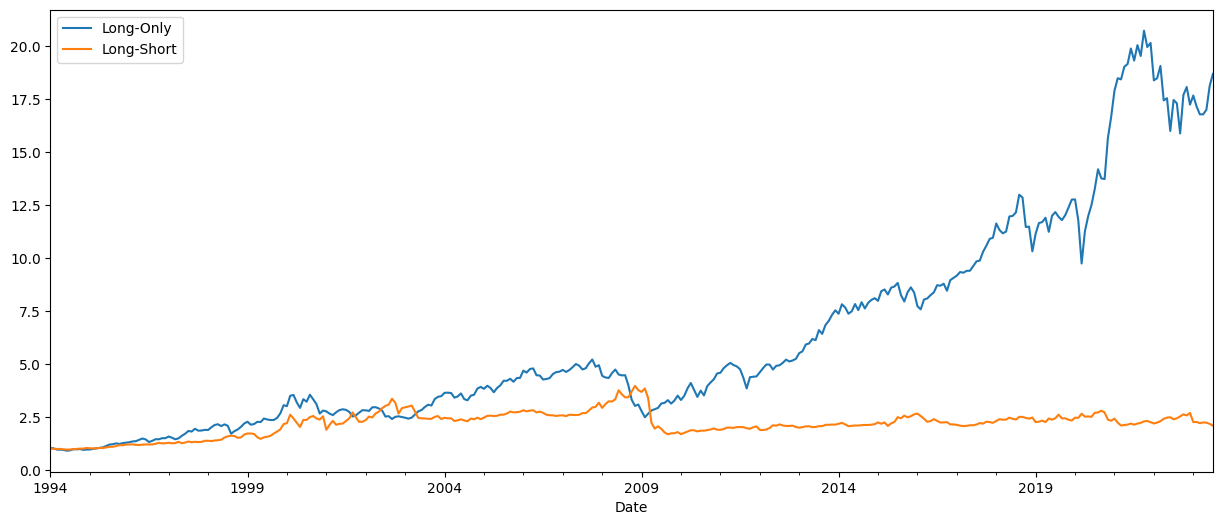

In [35]:
long_only_plot = pd.DataFrame(((1/2*(size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']))-rf['RF']),columns = ['Long-Only'])
long_short_plot = pd.DataFrame((1/2*((size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) 
                              - (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR']))),columns = ['Long-Short'])
mom_plot = pd.concat([long_only_plot, long_short_plot], axis = 1)
(1+mom_plot['1994':]).cumprod().plot()

### 3) Is momentum just data mining, or is it a robust strategy?

#### Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:


- #### long the top 1 decile and short the bottom 1 deciles:

#### $$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$


- #### long the top 3 deciles and short the bottom 3 deciles:


#### $$ \tilde{r}^{momD3} = \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)}) $$

#### $$ \tilde{r}^{momD3} = \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} $$


- #### long the top 5 deciles and short the bottom 5 decile:

#### $$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

In [41]:
mom_deciles.head(1)

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024


In [6]:
# long the top 1 decile and short the bottom 1 deciles:
mom_top1_decile = pd.DataFrame(mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR'],columns = ['UMD'])

# long the top 3 deciles and short the bottom 3 deciles:
mom_top3_decile = pd.DataFrame(1/3*((mom_deciles.loc[:,['PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (mom_deciles.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3']].sum(axis = 1))),columns = ['UMD'])

# long the top 5 deciles and short the bottom 5 decile:
mom_top5_decile = pd.DataFrame(1/5*((mom_deciles.loc[:,['PRIOR 6','PRIOR 7','PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (mom_deciles.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3','PRIOR 4','PRIOR 5']].sum(axis = 1))),columns = ['UMD'])
mom_top5_decile.head()

,UMD
Date,
1927-01-31,0.01450
1927-02-28,-0.02138
1927-03-31,0.04376
1927-04-30,0.02258
1927-05-31,0.01844


In [7]:
# The dict contained the three portfolios and an empty list for for loop traverse.
samples = {'Momentum Top 1 Decile':mom_top1_decile
          ,'Momentum Top 3 Decile':mom_top3_decile
          ,'Momentum Top 5 Decile':mom_top5_decile}

mom_deciles = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['UMD'] = v['UMD']
    mom_decile_summary = performance_summary(v['1994':])
    mom_decile_summary = mom_decile_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_decile_summary['Corr Mkt'] = ff.loc['1994':'2023'].corr().loc['MKT',['UMD']]
    mom_decile_summary['Corr Val'] = ff.loc['1994':'2023'].corr().loc['HML',['UMD']]
    mom_decile_summary.index = [k]
    mom_deciles.append(mom_decile_summary)
    
mom_deciles_df = pd.concat(mom_deciles)
mom_deciles_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Momentum Top 1 Decile,0.074873,0.298583,0.250762,-1.307240,-0.329943,-0.214096
Momentum Top 3 Decile,0.024814,0.194199,0.127774,-1.350529,-0.370049,-0.194311
Momentum Top 5 Decile,0.013016,0.134476,0.096792,-1.428013,-0.359342,-0.194664


### 2.3.b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

Intuitively, decile 1 performs well since it has a better Sharpe ratio here. However, this might lead to a higher idiosyncratic risk since it focuses on fewer assets and there may be a loss in diversification. Learning from lecture insights, the more extreme the cutoff for the 'winners', the higher the mean return of the momentum portfolio as we are long the most outperforming portfolio and shorting the worst portfolio, but it may come with higher risks. Indeed, we have a huge rise in volatility in the decile 1 portfolio with almost 30.00%. 

Overall, the top 3 decile strategy seems preferable for more downside tail risk protection while maintaining acceptable mean returns.

### 2.3.c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

If AQR wants to consider higher risk-adjusted returns, it should consider using 1-decile construction as the 5-decile construction provides an unfavourable Sharpe Ratio that will not be attractive for investors.

The 5-decile construction seems to mute the momentum effect overall, as it is weaker for less extreme (positive or negative) performers.

### 2.3.d) Does $\tilde{r}^{momD3}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

In [48]:
pd.concat([mom_rtn_long_short_summary, mom_deciles_df.loc['Momentum Top 3 Decile'].to_frame().T])

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Momentum Top 3 Decile,0.024814,0.194199,0.127774,-1.350529,-0.364613,-0.220764


In general, the FF long-short construction incorporating the size factor performs better than the momentum 3-decile in terms of the mean returns. They both have negative correlations with the market and value factors which indicates diversification opportunities. Also, the FF long-short strategy performs better given it has a better risk-adjusted return. The Sharpe Ratio of the FF long-short strategy is 0.24 while the 3-decile momentum is 0.13.

### 4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

#### For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)
#### Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

#### $$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

#### Similarly, use the data provided to construct a big-stock momentum portfolio,

#### $$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

### 2.4.a) Fill out Table 4 over the sample 1994-2023.


|<caption>Table 4: Momentum of small and big stocks.</caption>|1994-2023|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|All stocks, $\tilde{r}^{mom:FF}_t$|||||||||
|Small stocks, $\tilde{r}^{momS}_t$|||||||||
|Large stocks, $\tilde{r}^{momB}_t$|||||||||



In [36]:
# Use small-stock "winners" & small-stock "losers" to construct the portfolio
mom_small = pd.DataFrame((size_ports['SMALL HiPRIOR'] - size_ports['SMALL LoPRIOR']),columns = ['UMD'])

# Use big-stock "winners" & big-stock "losers" to construct the portfolio
mom_large = pd.DataFrame((size_ports['BIG HiPRIOR'] - size_ports['BIG LoPRIOR']),columns = ['UMD'])

In [60]:
samples = {'Small Stocks':mom_small
          ,'Large Stocks':mom_large}

mom_size = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['UMD'] = v['UMD']
    mom_size_summary = performance_summary(v['1994':])
    mom_size_summary = mom_size_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_size_summary['Corr Mkt'] = ff.loc['1994':].corr().loc['MKT',['UMD']]
    mom_size_summary['Corr Val'] = ff.loc['1994':].corr().loc['HML',['UMD']]
    mom_size_summary.index = [k]
    mom_size.append(mom_size_summary)
    

In [61]:
# Transform the list object into the dataframe using pd.concat method
mom_size_df = pd.concat(mom_size)
mom_size_df = pd.concat([mom_rtn_long_short_summary, mom_size_df])
mom_size_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Small Stocks,0.059358,0.171924,0.345256,-1.744008,-0.309153,-0.146270
Large Stocks,0.020799,0.183927,0.113082,-0.877121,-0.289410,-0.243587


### 2.4.b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

The volatility of small stocks is similar to the volatility of large stocks; the momentum strategy generates positive returns for both small stocks and large stocks. However, small stocks have 2 times the premia of momentum compared with large stocks and a better Sharpe Ratio, so it might be more attractive.  

This could be a reflection of small caps' potentially higher risk premia. However, investing more in small caps may translate into  higher transaction costs and bearing the higher risks due to sources like illiquidity, for example.

### 2.5) In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- AQR's long-short strategy tends to get a similar effect to that of Fama-French using size buckets. Indeed, it captures the positive risk premia, although there is a slight difference between long-short momentum and 3-decile momentum. 
- AQR's long-only approach may have a higher correlation with the Market factor, leading to a loss of diversification advantages. 
- AQR should try a different approach to reduce the correlation between the market factor and the momentum or create the momentum product in a long-short strategy using other forms of products such as ETF. 

---